## 5.1 Motivation for Hedging under Long-Memory Models

#### The effect of Hurst Parameter on Delta

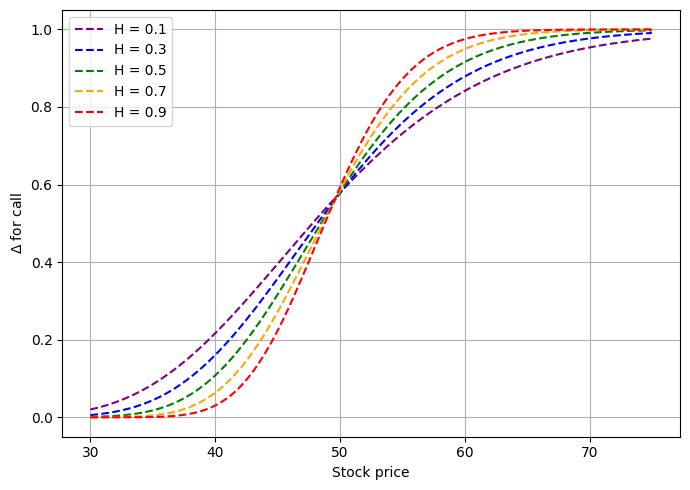

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# === Parameter ===
K = 50           # Strike price
r = 0.05         # Risk-free rate
sigma = 0.25     # Volatility
T = 20/52        # Time to maturity in years
S = np.linspace(30, 75, 200)  # Range of stock prices

# === Hurst exponents to compare ===
H_list = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = ['purple', 'blue', 'green', 'orange','red']
labels = ['H = 0.1', 'H = 0.3', 'H = 0.5', 'H = 0.7', 'H = 0.9']

# === Calculate delta ===
plt.figure(figsize=(7, 5))
for H, color, label in zip(H_list, colors, labels):
    tH = T**(2 * H)
    d1_H = (np.log(S / K) + r * T + 0.5 * sigma**2 * tH) / (sigma * np.sqrt(tH))
    delta_H = norm.cdf(d1_H)  # Delta under fBS
    plt.plot(S, delta_H, label=label, linestyle='--', color=color)

# === Plot ===
plt.xlabel("Stock price")
plt.ylabel(r"$\Delta$ for call")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.3 Delta Hedging Analysis for FRA and Caplet

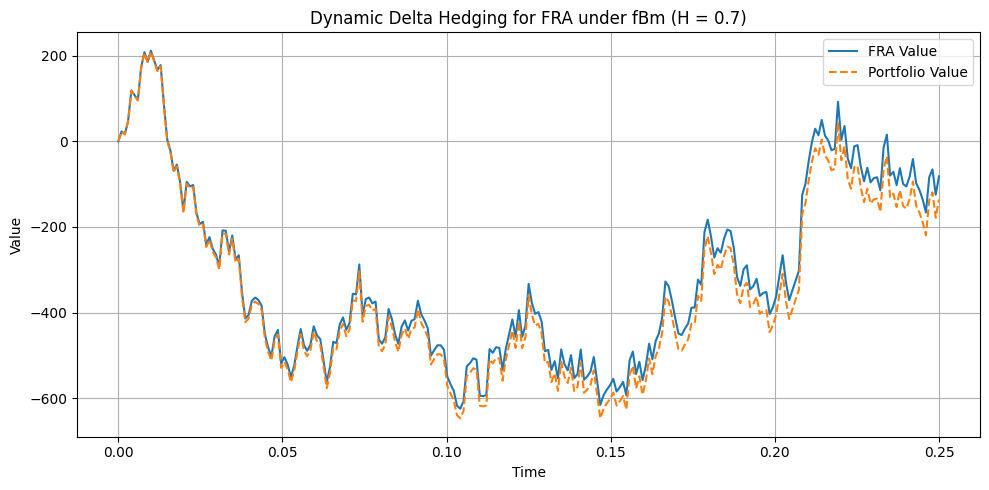

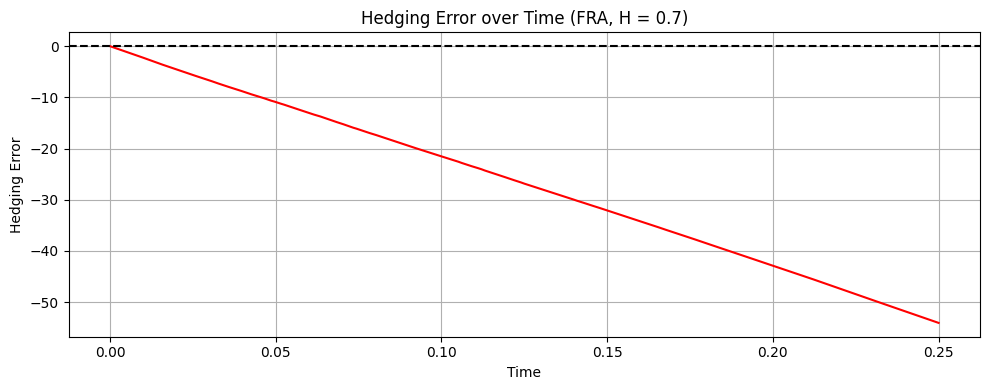

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# === Parameters ===
T = 0.25               # Time horizon (3 months)
n = 252                # Number of time steps
dt = T / n             # Time step
t_grid = np.linspace(0, T, n + 1)
np.random.seed(42)

# FRA contract parameters
N = 1_000_000          # Notional
tau = 0.25             # FRA maturity
K = 0.03               # FRA contract rate
r = 0.03               # Risk-free rate
sigma = 0.2            # Volatility
H = 0.7                # Hurst exponent

# Initial rate
L0 = 0.03

# === Simulate forward rate path using geometric fBm approximation ===
dB = np.random.randn(n) * np.sqrt(dt)
B = np.concatenate([[0], np.cumsum(dB)])
L_path = L0 * np.exp((0 - 0.5 * sigma**2) * t_grid + sigma * B)

# === Define FRA pricing and delta under fBm model ===
def discount_factor(t, T, L):
    return np.exp(-L * (T - t))

def fra_value(t, L):
    P = discount_factor(t, tau, L)
    return N * tau * (L - K) * P

def fra_delta(t, L):
    P = discount_factor(t, tau, L)
    return N * tau * P

# === Initialize portfolio arrays ===
fra_values = np.zeros(n + 1)
deltas = np.zeros(n + 1)
bond_vals = np.zeros(n + 1)
cash_vals = np.zeros(n + 1)
port_vals = np.zeros(n + 1)

# Initial values
fra_values[0] = fra_value(0, L_path[0])
deltas[0] = fra_delta(0, L_path[0])
bond_vals[0] = deltas[0] * L_path[0]
port_vals[0] = fra_values[0]
cash_vals[0] = port_vals[0] - bond_vals[0]

# === Dynamic hedging simulation ===
for i in range(1, n + 1):
    t = t_grid[i]
    fra_values[i] = fra_value(t, L_path[i])
    deltas[i] = fra_delta(t, L_path[i])
    bond_vals[i] = deltas[i] * L_path[i]
    cash_vals[i] = np.exp(r * dt) * (port_vals[i - 1] - deltas[i] * L_path[i - 1])
    port_vals[i] = bond_vals[i] + cash_vals[i]

# === Plot 1: Portfolio vs FRA ===
plt.figure(figsize=(10, 5))
plt.plot(t_grid, fra_values, label="FRA Value")
plt.plot(t_grid, port_vals, label="Portfolio Value", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Dynamic Delta Hedging for FRA under fBm (H = 0.7)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Hedging Error ===
hedging_error = port_vals - fra_values
plt.figure(figsize=(10, 4))
plt.plot(t_grid, hedging_error, color='red')
plt.xlabel("Time")
plt.ylabel("Hedging Error")
plt.title("Hedging Error over Time (FRA, H = 0.7)")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

Analyzing hedging performance across different Hurst parameters...
Simulating for Hurst = 0.5...
  Mean Error: -2
  Std Dev: 0
  RMSE: 2
  95% VaR: 3

Simulating for Hurst = 0.6...
  Mean Error: -2
  Std Dev: 1
  RMSE: 2
  95% VaR: 3

Simulating for Hurst = 0.7...
  Mean Error: -2
  Std Dev: 1
  RMSE: 3
  95% VaR: 4

Simulating for Hurst = 0.8...
  Mean Error: -3
  Std Dev: 3
  RMSE: 4
  95% VaR: 7

Simulating for Hurst = 0.9...
  Mean Error: -6
  Std Dev: 19
  RMSE: 20
  95% VaR: 19



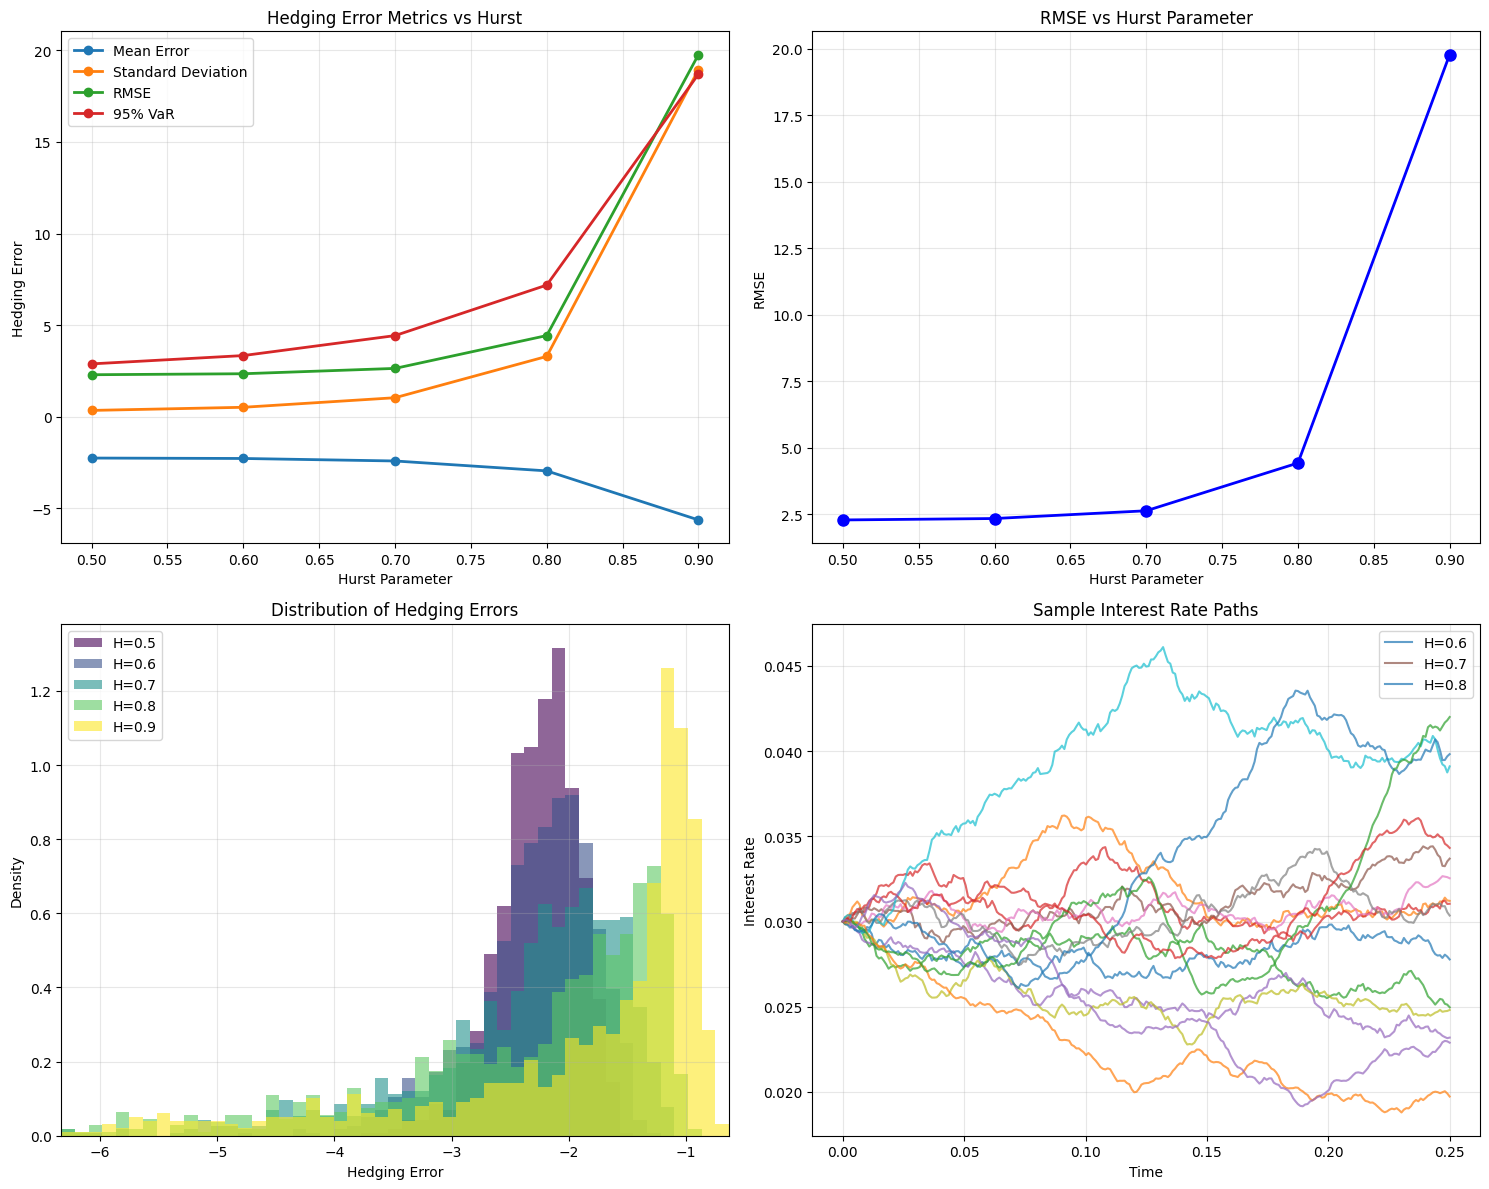

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import warnings
warnings.filterwarnings('ignore')


class FractionalBrownianMotion:
    """Fractional Brownian motion path generator using FFT"""
    
    def __init__(self, hurst: float, n_steps: int, T: float):
        self.hurst = hurst
        self.n_steps = n_steps
        self.T = T
        self.dt = T / n_steps
    
    def generate_fbm_fft(self, n_paths: int = 1) -> np.ndarray:
        H = self.hurst
        n = self.n_steps
        
        def autocovariance(k):
            return 0.5 * (abs(k-1)**(2*H) - 2*abs(k)**(2*H) + abs(k+1)**(2*H))
        
        r = np.zeros(2 * n)
        for k in range(2 * n):
            if k == 0:
                r[k] = 1.0
            elif k <= n:
                r[k] = autocovariance(k)
            else:
                r[k] = autocovariance(2 * n - k)
        
        lambda_vals = np.fft.fft(r).real
        lambda_vals = np.maximum(lambda_vals, 1e-10)
        
        paths = np.zeros((n_paths, n + 1))
        for i in range(n_paths):
            W = np.random.randn(2 * n)
            W_fft = np.fft.fft(W)
            sqrt_lambda = np.sqrt(lambda_vals)
            fbm_fft = sqrt_lambda * W_fft
            fbm_increments = np.fft.ifft(fbm_fft).real[:n]
            paths[i, 1:] = np.cumsum(fbm_increments) * np.sqrt(self.dt)
        
        return paths


class FRAHedging:
    """FRA dynamic delta hedging class"""
    
    def __init__(self, N: float, tau: float, K: float, r: float, sigma: float):
        self.N = N
        self.tau = tau
        self.K = K
        self.r = r
        self.sigma = sigma
    
    def fra_value(self, L: float, P: float) -> float:
        return self.N * self.tau * (L - self.K) * P
    
    def discount_factor(self, t: float, T: float, L: float) -> float:
        return np.exp(-L * (T - t))
    
    def forward_rate(self, t: float, L_t: float) -> float:
        return L_t
    
    def delta(self, t: float, L_t: float) -> float:
        P_t = self.discount_factor(t, self.tau, L_t)
        return self.N * self.tau * P_t
    
    def simulate_hedging(self, time_grid: np.ndarray, rate_paths: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        n_paths, n_steps = rate_paths.shape
        portfolio_values = np.zeros((n_paths, n_steps))
        hedging_errors = np.zeros(n_paths)
        
        for path_idx in range(n_paths):
            L_path = rate_paths[path_idx, :]
            L0 = L_path[0]
            P0 = self.discount_factor(0, self.tau, L0)
            V0_fra = self.fra_value(L0, P0)
            delta0 = self.delta(0, L0)
            bond_holdings = delta0 * L0
            cash_holdings = V0_fra - bond_holdings
            portfolio_values[path_idx, 0] = cash_holdings + bond_holdings
            
            for i in range(1, n_steps):
                t = time_grid[i]
                dt = time_grid[i] - time_grid[i - 1]
                L_t = L_path[i]
                L_prev = L_path[i - 1]
                P_t = self.discount_factor(t, self.tau, L_t)
                V_t = self.fra_value(L_t, P_t)
                delta_t = self.delta(t, L_t)
                cash_holdings *= np.exp(self.r * dt)
                cash_holdings -= (delta_t * L_t - delta0 * L_prev) * (L_t - L_prev)
                bond_holdings = delta_t * L_t
                portfolio_values[path_idx, i] = cash_holdings + bond_holdings
                delta0 = delta_t
            
            final_portfolio_value = portfolio_values[path_idx, -1]
            final_fra_value = self.fra_value(L_path[-1], self.discount_factor(time_grid[-1], self.tau, L_path[-1]))
            hedging_errors[path_idx] = final_portfolio_value - final_fra_value
        
        return portfolio_values, hedging_errors
    
def generate_rate_paths_fbm(hurst: float, n_paths: int, n_steps: int, T: float, 
                            r0: float, sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    """Generate interest rate paths driven by fBm using geometric Brownian motion dynamics"""
    fbm_gen = FractionalBrownianMotion(hurst, n_steps, T)
    fbm_paths = fbm_gen.generate_fbm_fft(n_paths)
    
    time_grid = np.linspace(0, T, n_steps + 1)
    rate_paths = np.zeros_like(fbm_paths)
    rate_paths[:, 0] = r0
    
    for i in range(1, n_steps + 1):
        dt = time_grid[i] - time_grid[i - 1]
        dW = fbm_paths[:, i] - fbm_paths[:, i - 1]
        rate_paths[:, i] = rate_paths[:, i - 1] * np.exp(
            (0.0 - 0.5 * sigma**2) * dt + sigma * dW
        )
    
    return rate_paths, time_grid


def analyze_hurst_impact():
    """Analyze the impact of the Hurst parameter on FRA hedging errors"""
    hurst_values = [0.5, 0.6, 0.7, 0.8, 0.9]
    n_paths = 1000
    n_steps = 252
    T = 0.25
    
    N = 1_000_000
    tau = 0.25
    K = 0.03
    r = 0.03
    sigma = 0.2
    r0 = 0.03
    
    results = {}
    
    print("Analyzing hedging performance across different Hurst parameters...")
    print("=" * 60)
    
    for hurst in hurst_values:
        print(f"Simulating for Hurst = {hurst:.1f}...")
        rate_paths, time_grid = generate_rate_paths_fbm(
            hurst, n_paths, n_steps, T, r0, sigma
        )
        
        fra_hedger = FRAHedging(N, tau, K, r, sigma)
        portfolio_values, hedging_errors = fra_hedger.simulate_hedging(time_grid, rate_paths)
        
        mean_error = np.mean(hedging_errors)
        std_error = np.std(hedging_errors)
        rmse = np.sqrt(np.mean(hedging_errors**2))
        var_95 = np.percentile(np.abs(hedging_errors), 95)
        
        results[hurst] = {
            'mean_error': mean_error,
            'std_error': std_error,
            'rmse': rmse,
            'var_95': var_95,
            'hedging_errors': hedging_errors,
            'rate_paths': rate_paths,
            'time_grid': time_grid
        }
        
        print(f"  Mean Error: {mean_error:,.0f}")
        print(f"  Std Dev: {std_error:,.0f}")
        print(f"  RMSE: {rmse:,.0f}")
        print(f"  95% VaR: {var_95:,.0f}\n")
    
    return results

def plot_results(results):
    """Plot summary results for hedging error analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    hurst_values = list(results.keys())
    metrics = ['mean_error', 'std_error', 'rmse', 'var_95']
    metric_names = ['Mean Error', 'Standard Deviation', 'RMSE', '95% VaR']
    
    # Bar plot of hedging error metrics
    ax = axes[0, 0]
    for metric, name in zip(metrics, metric_names):
        values = [results[h][metric] for h in hurst_values]
        ax.plot(hurst_values, values, 'o-', label=name, linewidth=2, markersize=6)
    ax.set_xlabel('Hurst Parameter')
    ax.set_ylabel('Hedging Error')
    ax.set_title('Hedging Error Metrics vs Hurst')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # RMSE line plot
    ax = axes[0, 1]
    rmse_values = [results[h]['rmse'] for h in hurst_values]
    ax.plot(hurst_values, rmse_values, 'bo-', linewidth=2, markersize=8)
    ax.set_xlabel('Hurst Parameter')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE vs Hurst Parameter')
    ax.grid(True, alpha=0.3)
    
    # Error distribution
    ax = axes[1, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(hurst_values)))

    all_errors = []
    for hurst in hurst_values:
        all_errors.extend(results[hurst]['hedging_errors'])
    
    x_min = np.percentile(all_errors, 5)
    x_max = np.percentile(all_errors, 95)
    x_range = x_max - x_min
    x_min -= 0.1 * x_range
    x_max += 0.1 * x_range
    
    bins = np.linspace(x_min, x_max, 50)
    
    for hurst, color in zip(hurst_values, colors):
        errors = results[hurst]['hedging_errors']
        ax.hist(errors, bins=bins, alpha=0.6, label=f'H={hurst:.1f}', 
                color=color, density=True)
    
    ax.set_xlabel('Hedging Error')
    ax.set_ylabel('Density')
    ax.set_title('Distribution of Hedging Errors')
    ax.set_xlim(x_min, x_max)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Example interest rate paths
    ax = axes[1, 1]
    for hurst in [0.6, 0.7, 0.8]:
        rate_paths = results[hurst]['rate_paths']
        time_grid = results[hurst]['time_grid']
        for i in range(5):
            if i == 0:
                ax.plot(time_grid, rate_paths[i, :], alpha=0.7, label=f'H={hurst:.1f}')
            else:
                ax.plot(time_grid, rate_paths[i, :], alpha=0.7)
    ax.set_xlabel('Time')
    ax.set_ylabel('Interest Rate')
    ax.set_title('Sample Interest Rate Paths')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    results = analyze_hurst_impact()
    plot_results(results)